In [1]:
%matplotlib inline
import scipy
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from functools import partial
from ipywidgets import interactive, FloatSlider, Layout
from IPython.display import display, SVG, HTML, Image, clear_output
import svgutils
import copy
import time
#from bqplot import pyplot as plt


In [2]:
# acceleration due to gravity
g = 9.81

In [3]:
# equivalent pendulum length of the bell
l_b = 0.6

# equivalent pendulum length of the clapper
l_c = 1

# distance from the bell axis to the clapper axis
c = 0.2

# angle of the clapper axis
alpha = 0

# clapper bounds
phi0 = -30 * np.pi / 180
phi1 = 30 * np.pi / 180

In [4]:
# initial conditions

# angle of the bell
theta_initial = 178

y0, t0 = [theta_initial * np.pi / 180, 0.0, phi1, 0.0], 0.0

In [5]:
def deriv(l_b, l_c, c, alpha, y, t):
    [theta, vtheta, phi, vphi] = y
    theta_dot  = vtheta
    vtheta_dot = - (g / l_b) * np.sin(theta)

    phi_dot = vphi

    # note sign error in the original notes 
    vphi_dot = -vtheta_dot * (1 + (c / l_c) * np.cos(phi - alpha)) \
               + (c / l_c) * (vtheta**2) * np.sin(phi - alpha) - (g / l_c) * np.sin(theta+phi)
    return np.array([theta_dot, vtheta_dot, phi_dot, vphi_dot])

In [6]:
def rk4(f, x, t, step):
    k1 = step * f(x, t)
    x1 = x + 0.5*k1
    k2 = step * f(x1, t+0.5*step)
    x2 = x + 0.5*k2
    k3 = step * f(x2, t+0.5*step)
    x3 = x + k3;
    k4 = step * f(x3, t+step)
    return (k1 + 2*k2 + 2*k3 + k4) / 6.0

In [7]:
def integrate_rk4(y0, tindex, l_b, l_c, c, alpha):
    y = []
    y.append(y0)
    t_last = tindex[0]
    for t in tindex[1:]:
        step = t - t_last
        y0 = y0 + rk4(partial(deriv, l_b, l_c, c, alpha), y0, t_last, step)
        # check for clapper clapping the bell
        if y0[2] > phi1:
            y0[2] = phi1
            y0[3] = 0
        elif y0[2] < phi0:
            y0[2] = phi0
            y0[3] = 0
        y.append(y0)
        t_last = t
    return np.array(y)

In [8]:
# period of small oscillations
T0 = 2 * np.pi * np.sqrt(l_b / g)
print('Period of small oscillations: {:.4} seconds'.format(T0))

Period of small oscillations: 1.554 seconds


In [9]:
# Lima-Arun formula, from arXiv:physics/0510206v3
aa = np.cos(y0[0]/2)
Tlog = -T0 * np.log(aa) / (1 - aa)
print('Lima-Arun approximation for the period: {:.4} seconds'.format(Tlog))

Lima-Arun approximation for the period: 6.402 seconds


In [10]:
# Exact formula from elliptic integral
Texact = 4 * np.sqrt(l_b / g) * scipy.special.ellipk(np.sin(y0[0]/2)**2)
print('Exact period: {:.4} seconds'.format(Texact))

Exact period: 5.376 seconds


In [11]:
t = np.linspace(t0, 2*Texact, 10000)
y = integrate_rk4(np.array(y0), t, l_b, l_c, alpha, c)

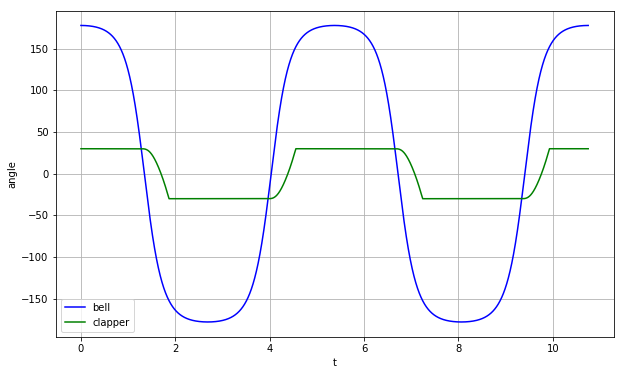

In [12]:
plt.figure(figsize=(10,6))
plt.plot(t, y[:,0] * 180 / np.pi, 'b', label='bell')
plt.plot(t, y[:,2] * 180 / np.pi, 'g', label='clapper')
#plt.plot(t, y[:,3] * 180 / np.pi, 'r', label='phi-dot(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('angle')
plt.grid()
plt.show()

In [13]:
def update(l_b, l_c, c, alpha):
    Texact = 4 * np.sqrt(l_b / g) * scipy.special.ellipk(np.sin(y0[0]/2)**2)
    t = np.linspace(t0, 2*Texact, 10000)
    y = integrate_rk4(np.array(y0), t, l_b, l_c, c, alpha*np.pi/180)
    plt.figure(figsize=(10,8))
    plt.plot(t, y[:,0] * 180 / np.pi, 'b', label='bell')
    plt.plot(t, y[:,2] * 180 / np.pi, 'g', label='clapper')
    plt.legend(loc='best')
    plt.xlabel('t')
    plt.ylabel('angle')
    plt.grid()
    plt.show()

In [14]:
mylayout = Layout(width='50%', height='20px')
l_b_float = FloatSlider(description=r'\(l_b\)', \
                        min=0.01, max=5, step=0.01, value=0.6, \
                        continuous_update=False, layout=mylayout)
l_c_float = FloatSlider(description=r'\(l_c\)', \
                        min=0.01, max=5, step=0.01, value=1, \
                        continuous_update=False, layout=mylayout)
c_float = FloatSlider(description=r'\(c\)', \
                      min=0.01, max=5, step=0.01, value=0.2, \
                      continuous_update=False, layout=mylayout)
alpha_float = FloatSlider(description=r'\(\alpha\)', \
                          min=-45, max=45, step=0.1, value=0, \
                          continuous_update=False, layout=mylayout)
interactive(update, l_b = l_b_float, l_c = l_c_float, c = c_float, alpha=alpha_float)

interactive(children=(FloatSlider(value=0.6, continuous_update=False, description='\\(l_b\\)', layout=Layout(height='20px', width='50%'), max=5.0, min=0.01, step=0.01), FloatSlider(value=1.0, continuous_update=False, description='\\(l_c\\)', layout=Layout(height='20px', width='50%'), max=5.0, min=0.01, step=0.01), FloatSlider(value=0.2, continuous_update=False, description='\\(c\\)', layout=Layout(height='20px', width='50%'), max=5.0, min=0.01, step=0.01), FloatSlider(value=0.0, continuous_update=False, description='\\(\\alpha\\)', layout=Layout(height='20px', width='50%'), max=45.0, min=-45.0), Output()), _dom_classes=('widget-interact',))

In [15]:
svg = svgutils.transform.fromfile('wheel_bell.svg')
image_width = float(svg.width)
image_height = float(svg.height)
bell_image = svg.getroot()

def get_bell_image(angle):
    bell_pic = copy.deepcopy(bell_image)
    bell_pic.rotate(-angle, image_width/2, image_height/2)
    return bell_pic

def show_bell(angle):
    bellfig = svgutils.transform.SVGFigure(image_width, image_height)
    bellfig.append(get_bell_image(angle))
    display(SVG(bellfig.to_str()))

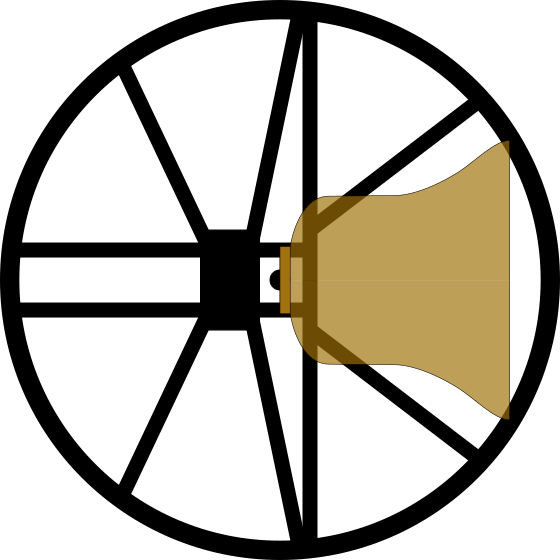

In [16]:
show_bell(90)

In [17]:
interactive(show_bell, angle = FloatSlider(min=-180,max=180,step=1))

interactive(children=(FloatSlider(value=0.0, description='angle', max=180.0, min=-180.0, step=1.0), Output()), _dom_classes=('widget-interact',))

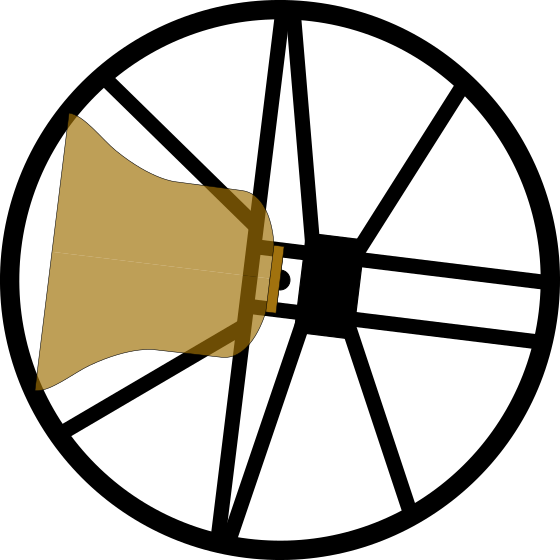

KeyboardInterrupt: 

In [24]:
angle = -180
while True:
    clear_output(wait=True)
    show_bell(angle)
    angle = angle + 1
    time.sleep(0.1)